In [1]:
%reset -sf

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob

In [3]:
tf.reset_default_graph()

In [4]:
#parameters
img_dir="C:/Desktop/Deep learning/project/img_align_celeba/"
z_dim=100
batch_size=32
gen_size1=4
gen_filter1=512
gen_filter2=gen_filter1//2
gen_filter3=gen_filter2//2
gen_filter4=gen_filter3//2
img_filter=3

dis_filter1=64
dis_filter2=dis_filter1*2
dis_filter3=dis_filter2*2
dis_filter4=dis_filter3*2

img_size=64
stddev=0.02  
learning_rate=0.0002
epochs=1
restore=True

In [5]:
def crop_resize(image_path, batch_num,resize_shape=(img_size,img_size)):
    image = cv2.imread(image_path)
    height, width, channel = image.shape

    if width == height:
        resized_image = cv2.resize(image, resize_shape)
    elif width > height:
        resized_image = cv2.resize(image, (int(width * float(resize_shape[0])/height), resize_shape[1]))
        cropping_length = int( (resized_image.shape[1] - resize_shape[0]) / 2)
        resized_image = resized_image[:,cropping_length:cropping_length+resize_shape[1]]
    else:
        resized_image = cv2.resize(image, (resize_shape[0], int(height * float(resize_shape[1])/width)))
        cropping_length = int( (resized_image.shape[0] - resize_shape[1]) / 2)
        resized_image = resized_image[cropping_length:cropping_length+resize_shape[0], :]

    return resized_image/127.5 - 1

In [6]:
#load batch of images
img_name= list(filter(lambda x: x.endswith(".jpg"),os.listdir(img_dir)))
np.random.shuffle(img_name)


def load_img(batch_size,batch_num):
    imgs=[]

    for i in range(batch_size):
        image_path=img_dir+str(img_name[batch_size*batch_num+i])
        img=crop_resize(image_path, batch_num,resize_shape=(img_size,img_size))
        imgs.append(img)
    
    return np.array(imgs)


In [7]:
real_img=tf.placeholder(dtype=tf.float32,shape=(None,img_size,img_size,3))
input_Z=tf.placeholder(dtype=tf.float32,shape=(None,100))
training= tf.placeholder(tf.bool)

In [8]:
def lrelu(x,alpha=0.2):
    return tf.maximum(0.2*x,x)

In [9]:
def deconv_2d(input_,filter_,kern_size,stride,activation_=None,pad="same",stddev=0.02):
    
    deconv=tf.layers.conv2d_transpose(inputs=input_,filters=filter_,kernel_size=kern_size,
                                      strides=stride,padding=pad,
                                      kernel_initializer=tf.random_normal_initializer(stddev=stddev),
                                      activation=activation_)
    
    return deconv


In [10]:
#generator
def generator(x,train=True):
    with tf.variable_scope("generator", reuse=False if train==True else True):
        flat_layer1=tf.layers.dense(x,(gen_size1*gen_size1*gen_filter1),
                                    kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        L1=tf.reshape(flat_layer1,shape=[batch_size,gen_size1,gen_size1,gen_filter1])
        L1=tf.nn.relu(L1)
        
        L2=deconv_2d(L1,gen_filter2,5,2,tf.nn.relu,pad="same",stddev=stddev)
        bn2=tf.layers.batch_normalization(L2,training=train)
        
        L3=deconv_2d(bn2,gen_filter3,5,2,tf.nn.relu,pad="same",stddev=stddev)
        bn3=tf.layers.batch_normalization(L3,training=train)
        
        L4=deconv_2d(bn3,gen_filter4,5,2,tf.nn.relu,pad="same",stddev=stddev)
        bn4=tf.layers.batch_normalization(L4,training=train)
        
        L5=deconv_2d(bn4,img_filter,5,2,None,pad="same",stddev=stddev)
        
        
        L5=tf.nn.tanh(L5)

        
    return L5

In [11]:
def conv2d(input_,filter_,kern_size,stride,activation_,pad="same",stddev=0.02):
    L1=tf.layers.conv2d(inputs=input_,filters=filter_,kernel_size=kern_size,strides=stride
                        ,activation=activation_,padding=pad,
                        kernel_initializer=tf.random_normal_initializer(stddev=stddev))
    return L1

In [12]:
def discriminate(input_,train,reuse=False):
    with tf.variable_scope("disc", reuse=reuse):
        L1=conv2d(input_,dis_filter1,5,2,lrelu,pad="same",stddev=0.02)
        bn1=tf.layers.batch_normalization(L1,training=train)
        
        L2=conv2d(bn1,dis_filter2,5,2,lrelu,pad="same",stddev=0.02)
        bn2=tf.layers.batch_normalization(L2,training=train)
        
        L3=conv2d(bn2,dis_filter3,5,2,lrelu,pad="same",stddev=0.02)
        bn3=tf.layers.batch_normalization(L3,training=train)
        
        L4=conv2d(bn3,dis_filter4,5,2,lrelu,pad="same",stddev=0.02)
        bn4=tf.layers.batch_normalization(L4,training=train)
        
        L5=tf.reshape(bn4,shape=[batch_size,4*4*dis_filter4])
        logit=tf.layers.dense(inputs=L5,units=1,kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        out=tf.nn.sigmoid(logit)
        
    return out, logit


In [13]:
def dcgans(img,z,train=True):
    img_fake=generator(input_Z,train=True)
    out_disc_fake,logit_disc_fake=discriminate(img_fake,train=train,reuse=False)
    out_disc_real,logit_disc_real=discriminate(img,train=train,reuse=True)
    
    d_loss_fake= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logit_disc_fake),logits=logit_disc_fake))
    d_loss_real= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logit_disc_real),logits=logit_disc_real))
    g_loss= tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logit_disc_fake),logits=logit_disc_fake))
    
    
    d_loss_sum=d_loss_fake+d_loss_real
    
    
    t_vars=tf.trainable_variables()
    d_vars=[var for var in t_vars if var.name.startswith("disc")]
    g_vars=[var for var in t_vars if var.name.startswith("generator")]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): 
        g_train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(g_loss,var_list=g_vars)
        d_train=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_sum,var_list=d_vars)
        
    
    
    return g_train,d_train,g_loss,d_loss_sum

In [14]:
g_train,d_train,g_loss,d_loss_sum=dcgans(real_img,input_Z,training)

In [15]:
saver = tf.train.Saver()

sess=tf.Session()

if (restore==True):
    saver.restore(sess, "./model")
    print("Model restored.")
else:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())

INFO:tensorflow:Restoring parameters from ./model
Model restored.


In [ ]:
for epoch in range(epochs):
    for i in range(len(img_name)//batch_size):
        Z=np.random.uniform(-1, 1, size=[batch_size, z_dim]).astype(np.float32)
        img_batch=load_img(batch_size,i)
        
        with tf.device('/gpu:0'):
            _,dloss=sess.run([d_train,d_loss_sum],feed_dict={real_img:img_batch,input_Z:Z,training:True})
            _,gloss=sess.run([g_train,g_loss],feed_dict={real_img:img_batch,input_Z:Z,training:True})
    

        if (i%100==0):
            print("discriminator_loss:{}".format(dloss))
            print("generator_loss:{}".format(gloss))
        
        if(i%400==0):
            save_path = saver.save(sess, "./model",global_step=i)
            print("Model saved in path: %s" % save_path)
            a=sess.run(generator(input_Z,train=training),feed_dict={real_img:img_batch,input_Z:Z,training:False})
            cv2.imwrite("C:/Deep learning/project/face/vis/"+str(i)+".png",(a[0,...]+1.)*127.5)

discriminator_loss:0.04320420324802399
generator_loss:7.598213195800781
Model saved in path: ./model-0
discriminator_loss:0.022603442892432213
generator_loss:6.488251686096191
discriminator_loss:0.013235383667051792
generator_loss:11.831184387207031
discriminator_loss:0.020733986049890518
generator_loss:10.020547866821289
discriminator_loss:0.05553687736392021
generator_loss:7.445965766906738
Model saved in path: ./model-400
discriminator_loss:0.06603589653968811
generator_loss:10.39197063446045
discriminator_loss:0.0953136458992958
generator_loss:6.193470001220703
discriminator_loss:0.7188040018081665
generator_loss:8.784385681152344
discriminator_loss:0.5288658738136292
generator_loss:6.330685615539551
Model saved in path: ./model-800
discriminator_loss:0.03925750404596329
generator_loss:7.580720901489258
discriminator_loss:0.07430591434240341
generator_loss:8.830081939697266
discriminator_loss:0.2054368257522583
generator_loss:3.5655436515808105
discriminator_loss:0.0710497796535492

In [54]:
a=sess.run(generator(input_Z,train=training),feed_dict={real_img:img_batch,input_Z:Z,training:False})

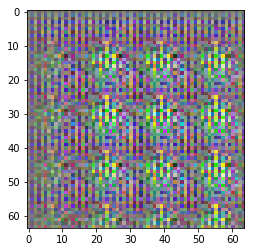

In [55]:
plt.imshow(a[15,...])

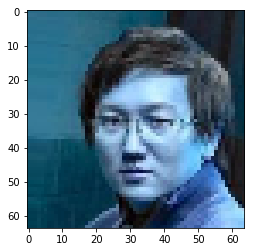

In [62]:
plt.imshow((img_batch[10,...]+1.)/2.)